Comparison of Rating Systems

Rating Systems Summary:
                                                          Description  \
PPG_System          Points Per Game (Win=3, Draw=1, Loss=0) scaled...   
Elo_With_Goal_Diff       Elo system with goal differential multiplier   
Standard_Elo                  Standard Elo system with fixed K-factor   

                    Mean Rating    Std Dev  
PPG_System            48.949537  27.941883  
Elo_With_Goal_Diff    52.644806  18.224539  
Standard_Elo          51.638285  19.359998  

Correlation Between Systems:
                    PPG_System  Elo_With_Goal_Diff  Standard_Elo
PPG_System            1.000000            0.803616      0.803969
Elo_With_Goal_Diff    0.803616            1.000000      0.982820
Standard_Elo          0.803969            0.982820      1.000000

Spearman Rank Correlation:
                    PPG_System  Elo_With_Goal_Diff  Standard_Elo
PPG_System            1.000000            0.880407      0.874366
Elo_With_Goal_Diff    0.8

Text(0.5, 0.98, 'Comparison of Three Rating Systems')

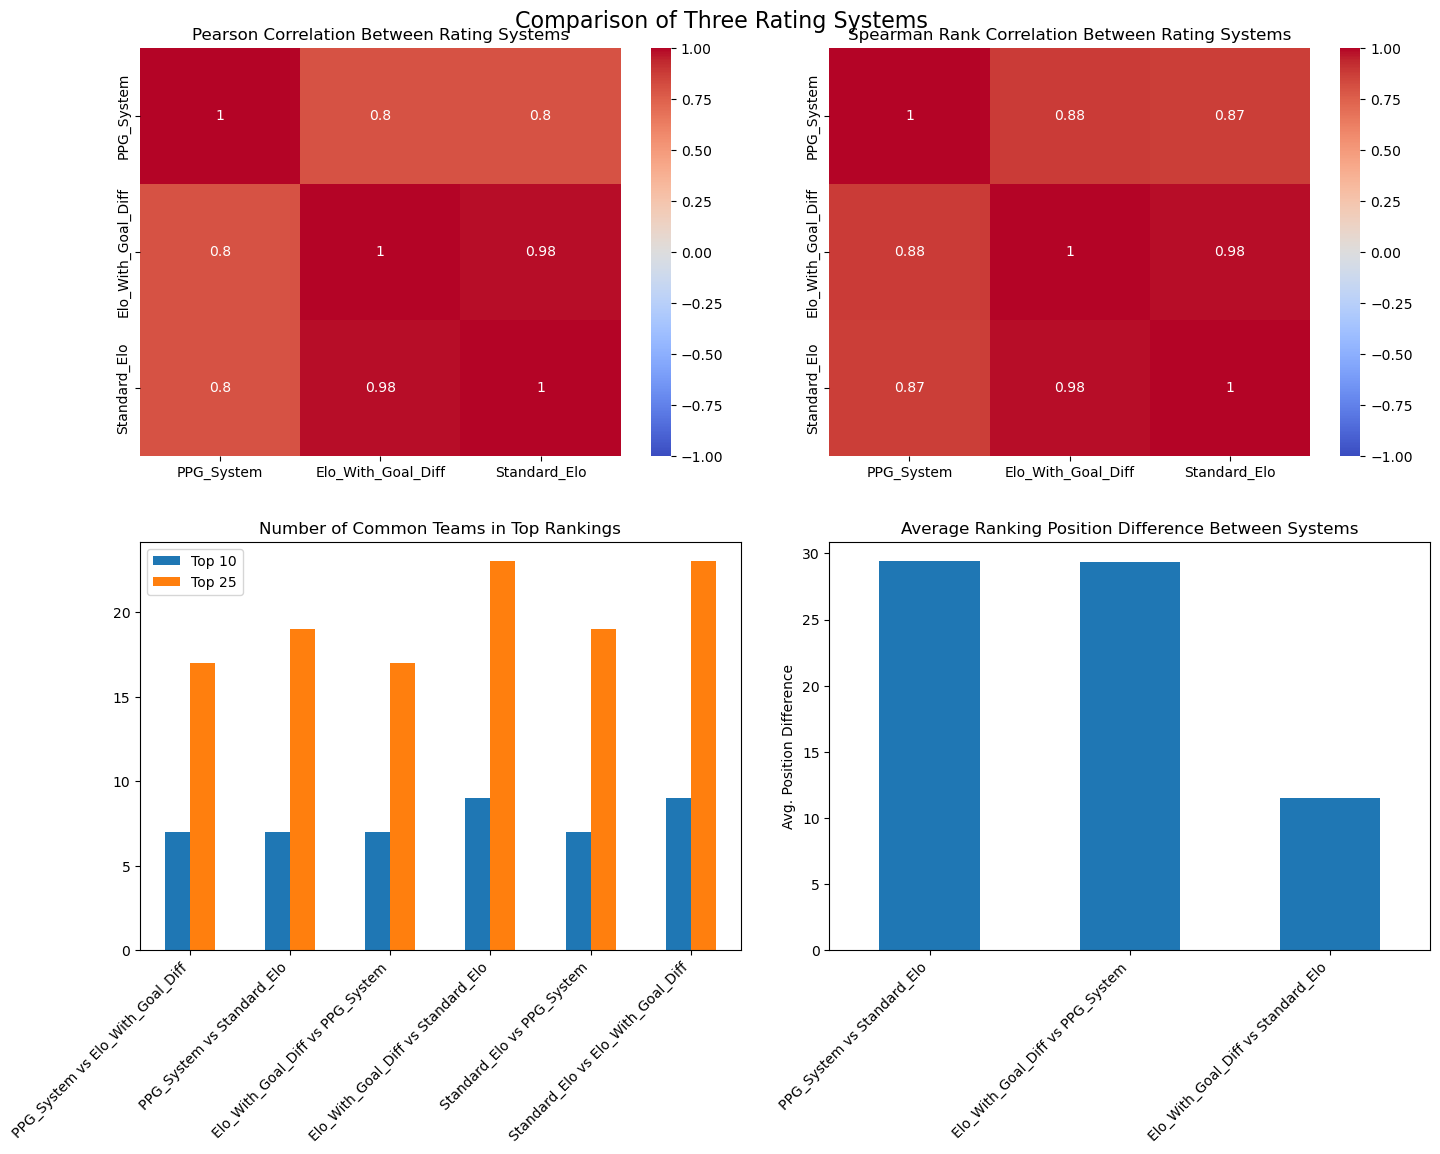

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau

# Load data
file_path = r"C:\Users\maxwe\Player and Team Ratings\NCAA\ncaa_mens_scores_2024.csv"
games_df = pd.read_csv(file_path)

# Function for rating system 1 (Gemini's - Points Per Game based)
def rating_system_1(df):
    from collections import defaultdict
    
    # Use defaultdict to easily handle teams when they first appear
    team_points = defaultdict(int)
    team_games_played = defaultdict(int)
    
    # Iterate through each game to assign points
    for _, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        home_score = row['home_team_score']
        away_score = row['away_team_score']
        
        # Increment games played for both teams
        team_games_played[home_team] += 1
        team_games_played[away_team] += 1
        
        # Assign points based on outcome
        if home_score > away_score:  # Home team wins
            team_points[home_team] += 3
            team_points[away_team] += 0
        elif home_score < away_score:  # Away team wins
            team_points[home_team] += 0
            team_points[away_team] += 3
        else:  # Draw
            team_points[home_team] += 1
            team_points[away_team] += 1
    
    # Calculate Points Per Game (PPG)
    teams = list(team_games_played.keys())
    ppg = {}
    for team in teams:
        if team_games_played[team] > 0:
            ppg[team] = team_points[team] / team_games_played[team]
        else:
            ppg[team] = 0
    
    ppg_series = pd.Series(ppg, name="PPG").sort_values(ascending=False)
    
    # Scale PPG to 1-100
    min_ppg = ppg_series.min()
    max_ppg = ppg_series.max()
    
    # Handle cases where all teams have the same PPG
    if max_ppg == min_ppg:
        scaled_ratings = pd.Series([50.0] * len(ppg_series), index=ppg_series.index, name="Rating")
    else:
        # Apply Min-Max scaling
        scaled_ratings = 1 + (ppg_series - min_ppg) * 99 / (max_ppg - min_ppg)
        scaled_ratings.name = "Rating"
    
    return scaled_ratings.sort_values(ascending=False)

# Function for rating system 2 (ChatGPT's - Elo with goal differential)
def rating_system_2(df):
    # Get a list of all unique teams
    teams = pd.unique(df[['home_team', 'away_team']].values.ravel())
    
    # Initialize ratings
    ratings = pd.Series(1000, index=teams, dtype=float)
    
    # Function to calculate expected score
    def expected_score(rating_a, rating_b):
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    # Rating parameters
    K = 20
    num_iterations = 10
    
    # Iteratively update ratings
    for _ in range(num_iterations):
        for _, row in df.iterrows():
            home = row['home_team']
            away = row['away_team']
            home_score = row['home_team_score']
            away_score = row['away_team_score']
            
            # Determine actual result
            if home_score > away_score:
                home_result = 1
            elif home_score < away_score:
                home_result = 0
            else:
                home_result = 0.5
            away_result = 1 - home_result
            
            # Expected results
            expected_home = expected_score(ratings[home], ratings[away])
            expected_away = expected_score(ratings[away], ratings[home])
            
            # Add a small bonus for goal differential
            goal_diff = home_score - away_score
            margin_multiplier = np.log(abs(goal_diff) + 1) if goal_diff != 0 else 1
            
            # Update ratings
            ratings[home] += K * margin_multiplier * (home_result - expected_home)
            ratings[away] += K * margin_multiplier * (away_result - expected_away)
    
    # Normalize ratings to 1-100 scale
    min_rating = ratings.min()
    max_rating = ratings.max()
    normalized_ratings = ((ratings - min_rating) / (max_rating - min_rating)) * 99 + 1
    
    return normalized_ratings.round(2)

# Function for rating system 3 (Claude's - Elo system)
def rating_system_3(df):
    # Extract unique teams
    all_teams = pd.unique(df[['home_team', 'away_team']].values.ravel())
    
    # Initialize ratings dictionary
    initial_rating = 1500
    ratings = {team: initial_rating for team in all_teams}
    
    # Define function to calculate expected outcome
    def expected_outcome(rating_a, rating_b):
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    # Define function to determine actual outcome
    def actual_outcome(score_a, score_b):
        if score_a > score_b:
            return 1.0
        elif score_a < score_b:
            return 0.0
        else:
            return 0.5  # Draw
    
    # Rating parameters
    k_factor = 32
    iterations = 10
    
    # Iterate through games multiple times for convergence
    for _ in range(iterations):
        for _, row in df.iterrows():
            home_team = row['home_team']
            away_team = row['away_team']
            home_score = row['home_team_score']
            away_score = row['away_team_score']
            
            # Get current ratings
            home_rating = ratings[home_team]
            away_rating = ratings[away_team]
            
            # Calculate expected outcomes
            home_expected = expected_outcome(home_rating, away_rating)
            away_expected = expected_outcome(away_rating, home_rating)
            
            # Calculate actual outcomes
            home_actual = actual_outcome(home_score, away_score)
            away_actual = actual_outcome(away_score, home_score)
            
            # Update ratings
            ratings[home_team] += k_factor * (home_actual - home_expected)
            ratings[away_team] += k_factor * (away_actual - away_expected)
    
    # Create Series from ratings dictionary
    ratings_series = pd.Series(ratings)
    
    # Scale ratings from 1 to 100
    min_rating = ratings_series.min()
    max_rating = ratings_series.max()
    scaled_ratings = 1 + 99 * (ratings_series - min_rating) / (max_rating - min_rating)
    
    return scaled_ratings

# Calculate ratings using all three systems
ratings_1 = rating_system_1(games_df)
ratings_2 = rating_system_2(games_df)
ratings_3 = rating_system_3(games_df)

# Combine all ratings into a single DataFrame
combined_ratings = pd.DataFrame({
    'PPG_System': ratings_1,
    'Elo_With_Goal_Diff': ratings_2,
    'Standard_Elo': ratings_3
})

# Calculate correlation matrix
correlation_matrix = combined_ratings.corr()

# Calculate rank correlation (Spearman's rho)
spearman_corr = pd.DataFrame(
    data=spearmanr(combined_ratings)[0],
    index=combined_ratings.columns,
    columns=combined_ratings.columns
)

# Calculate rank correlation (Kendall's tau)
kendall_corr = pd.DataFrame()
for col1 in combined_ratings.columns:
    for col2 in combined_ratings.columns:
        kendall_corr.loc[col1, col2] = kendalltau(combined_ratings[col1], combined_ratings[col2])[0]

# Find top 25 teams from each system
top_25_systems = {}
for column in combined_ratings.columns:
    top_25_systems[column] = combined_ratings[column].sort_values(ascending=False).head(25)

# Create a function to compare top N teams across systems
def compare_top_n(df, n=25):
    top_teams = {}
    for column in df.columns:
        top_teams[column] = set(df[column].sort_values(ascending=False).head(n).index)
    
    # Calculate overlap between systems
    overlap = {}
    for sys1 in df.columns:
        for sys2 in df.columns:
            if sys1 != sys2:
                key = f"{sys1} vs {sys2}"
                common = top_teams[sys1].intersection(top_teams[sys2])
                overlap[key] = len(common)
    
    return pd.Series(overlap)

# Calculate overlap for top 10 and top 25 teams
top_10_overlap = compare_top_n(combined_ratings, 10)
top_25_overlap = compare_top_n(combined_ratings, 25)

# Calculate average position difference for teams
def avg_position_diff(df):
    # Get team rankings for each system
    rankings = {}
    for column in df.columns:
        rankings[column] = pd.Series(range(1, len(df) + 1), 
                                     index=df[column].sort_values(ascending=False).index)
    
    # Calculate position differences between systems
    diff_dict = {}
    for sys1 in df.columns:
        for sys2 in df.columns:
            if sys1 < sys2:  # To avoid duplicates
                key = f"{sys1} vs {sys2}"
                # Get common teams
                common_teams = set(rankings[sys1].index).intersection(set(rankings[sys2].index))
                # Calculate absolute difference in rankings
                diffs = [abs(rankings[sys1][team] - rankings[sys2][team]) for team in common_teams]
                diff_dict[key] = sum(diffs) / len(diffs)
    
    return pd.Series(diff_dict)

# Calculate average ranking differences
avg_diffs = avg_position_diff(combined_ratings)

# Generate visualizations
def plot_comparisons():
    # Set figure size
    plt.figure(figsize=(15, 12))
    
    # Plot correlation heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Pearson Correlation Between Rating Systems')
    
    # Plot Spearman correlation heatmap
    plt.subplot(2, 2, 2)
    sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Spearman Rank Correlation Between Rating Systems')
    
    # Plot team overlap
    plt.subplot(2, 2, 3)
    overlap_df = pd.DataFrame({'Top 10': top_10_overlap, 'Top 25': top_25_overlap})
    overlap_df.plot(kind='bar', ax=plt.gca())
    plt.title('Number of Common Teams in Top Rankings')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Plot average position differences
    plt.subplot(2, 2, 4)
    avg_diffs.plot(kind='bar', ax=plt.gca())
    plt.title('Average Ranking Position Difference Between Systems')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Avg. Position Difference')
    plt.tight_layout()
    
    plt.tight_layout(pad=3.0)
    return plt

# Create a function to show the most differently rated teams
def find_rank_disagreements(df, threshold=25):
    # Get team rankings for each system
    rankings = {}
    for column in df.columns:
        rankings[column] = pd.Series(range(1, len(df) + 1), 
                                     index=df[column].sort_values(ascending=False).index)
    
    # Calculate the maximum difference in rankings for each team
    max_diffs = {}
    for team in df.index:
        ranks = [rankings[sys][team] if team in rankings[sys].index else np.nan for sys in df.columns]
        if not all(np.isnan(r) for r in ranks):
            valid_ranks = [r for r in ranks if not np.isnan(r)]
            max_diffs[team] = max(valid_ranks) - min(valid_ranks)
    
    # Sort by maximum difference
    max_diffs = pd.Series(max_diffs).sort_values(ascending=False)
    
    # Return teams with significant disagreement
    return max_diffs[max_diffs > threshold].head(10)

# Execute the comparison
disagreements = find_rank_disagreements(combined_ratings)

# Create report of results
def generate_comparison_report():
    # Top 10 teams from each system
    top_10_report = pd.DataFrame()
    for column in combined_ratings.columns:
        top_teams = combined_ratings[column].sort_values(ascending=False).head(10)
        top_10_report[column] = top_teams.index
    
    # Systems summary
    systems_summary = pd.DataFrame({
        'Description': [
            'Points Per Game (Win=3, Draw=1, Loss=0) scaled to 1-100',
            'Elo system with goal differential multiplier',
            'Standard Elo system with fixed K-factor'
        ],
        'Mean Rating': [
            combined_ratings['PPG_System'].mean(),
            combined_ratings['Elo_With_Goal_Diff'].mean(), 
            combined_ratings['Standard_Elo'].mean()
        ],
        'Std Dev': [
            combined_ratings['PPG_System'].std(),
            combined_ratings['Elo_With_Goal_Diff'].std(),
            combined_ratings['Standard_Elo'].std()
        ]
    }, index=combined_ratings.columns)
    
    return {
        'correlation_matrix': correlation_matrix,
        'spearman_correlation': spearman_corr,
        'kendall_correlation': kendall_corr,
        'top_10_teams': top_10_report,
        'top_team_overlap': {'Top 10': top_10_overlap, 'Top 25': top_25_overlap},
        'ranking_disagreements': disagreements,
        'systems_summary': systems_summary,
        'avg_position_diff': avg_diffs
    }

# Generate the report
comparison_report = generate_comparison_report()

# Display results
print("Comparison of Rating Systems")
print("==========================")
print("\nRating Systems Summary:")
print(comparison_report['systems_summary'])

print("\nCorrelation Between Systems:")
print(comparison_report['correlation_matrix'])

print("\nSpearman Rank Correlation:")
print(comparison_report['spearman_correlation'])

print("\nTop 10 Teams By System:")
print(comparison_report['top_10_teams'])

print("\nTop Teams Overlap Between Systems:")
print(pd.DataFrame(comparison_report['top_team_overlap']))

print("\nTeams with Greatest Ranking Disagreement:")
print(comparison_report['ranking_disagreements'])

print("\nAverage Position Difference Between Systems:")
print(comparison_report['avg_position_diff'])

# Create plot
plt = plot_comparisons()
plt.suptitle('Comparison of Three Rating Systems', fontsize=16)